# **Projet Apprentissage non supervisé**

> **Lilia Harireche - Antoine Rodriguez** : MLDS FA

Dans ce projet, nous allons utiliser des méthodes d'apprentissage automatique non supervisé dans le but de reconnaitre, à partir des données d’accélération et de vitesse mesurées à l'aide de smartphones, différentes types d’activités
physiques exercées par l'utilisateur : marcher, monter les escaliers, descendre les escaliers, s’asseoir, se lever, et s’allonger.

Nous allons ainsi discuter des résultats obtenus à l'issue de cette étude.

# **Partie 1: exploration des données**



## **1. Importation des données**

Les données que nous avons à notre disposition sont des relevés de mesures effectué sur 30 personnes exerçant les 6 types d'activités.

In [ ]:
# chargement des jeux de données
data = read.table("http://allousame.free.fr/mlds/tp/data.txt",
                  header = FALSE, sep = "", dec = ".")
data2 = read.table("http://allousame.free.fr/mlds/tp/data2.txt",
                  header = FALSE, sep = "", dec = ".")
labels = read.table("http://allousame.free.fr/mlds/tp/labels.txt",
                    header = FALSE, sep = "", dec = ".")
id = read.table("http://allousame.free.fr/mlds/tp/id.txt",
                header = FALSE, sep = "", dec = ".")
                

## **2 .Représentation des données**

Ces données sont regroupées en 7352 "individus" qui sont des mesures d'accélération et de vitesse angulaire dans l'espace selon différents axes et pendant 2,5 secondes pour un total de 1152 variables. On peux représenter celles-ci pour le premier individu par exemple :

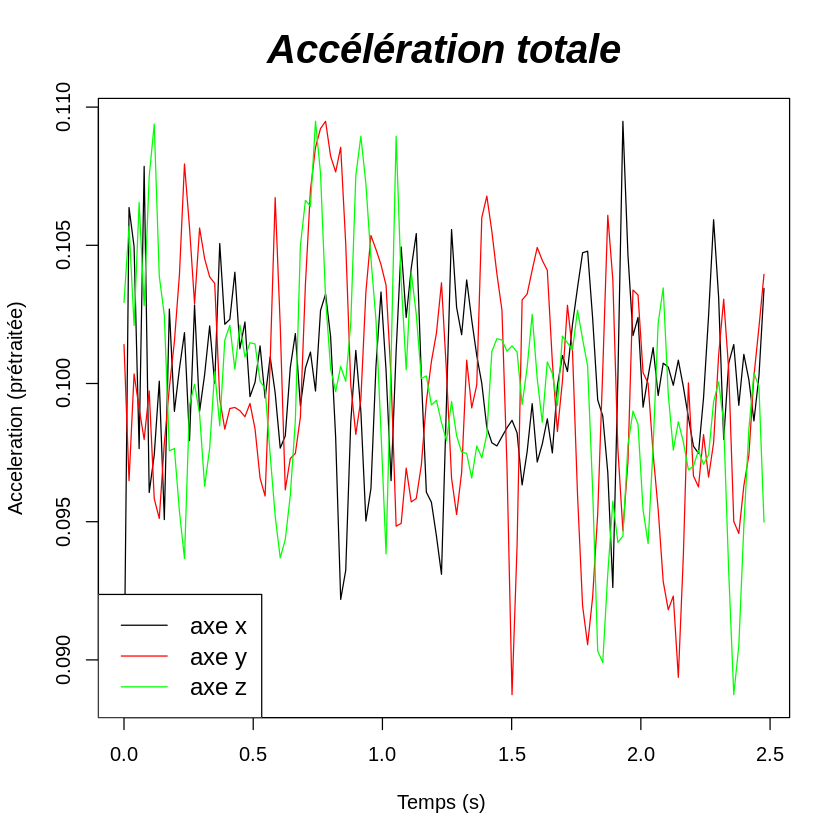

In [ ]:
# découpage de la séquence temporelle pour un affichage en secondes
time_seq = seq(from=0, by=0.0195, length.out=128)  

# Accélération totale
plot(time_seq, data[1,1:128], type='l', xlab = "", ylab = "", axes=FALSE)
par(new = TRUE)
plot(time_seq, data[1,129:256], col="red",
     type='l' , xlab = "", ylab = "", axes=FALSE)
par(new = TRUE)
plot(time_seq, data[1,257:384],
     col="green",  type='l' , xlab = "", ylab = "")
title(main = "Accélération totale",
      xlab = "Temps (s) ", ylab = "Acceleration (prétraitée)",
      cex.main = 2,   font.main= 4,
      cex.sub = 0.75, font.sub = 3,
      )
legend('bottomleft', legend=c("axe x", "axe y","axe z"),
       col=c("black", "red","green"),lty=1, cex=1.2)

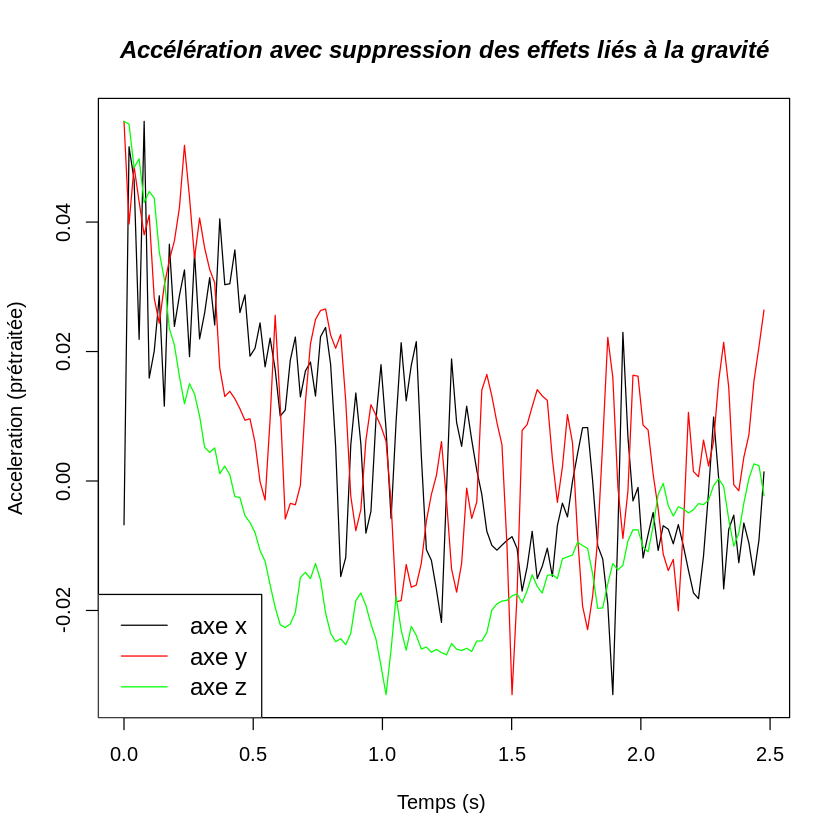

In [ ]:
#Accélération moins gravité
plot(time_seq, data[1,385:512], type='l', xlab = "", ylab = "", axes=FALSE)
par(new = TRUE)
plot(time_seq, data[1,513:640], col="red",  type='l' , xlab = "",
     ylab = "", axes=FALSE)
par(new = TRUE)
plot(time_seq, data[1,641:768], col="green",  type='l' , xlab = "", ylab = "")
title(main = "Accélération avec suppression des effets liés à la gravité",
      xlab = "Temps (s) ", ylab = "Acceleration (prétraitée)",
      cex.main = 1.2,   font.main= 4,
      cex.sub = 0.75, font.sub = 3,
      )
legend('bottomleft', legend=c("axe x", "axe y","axe z"),
       col=c("black", "red","green"),lty=1, cex=1.2)

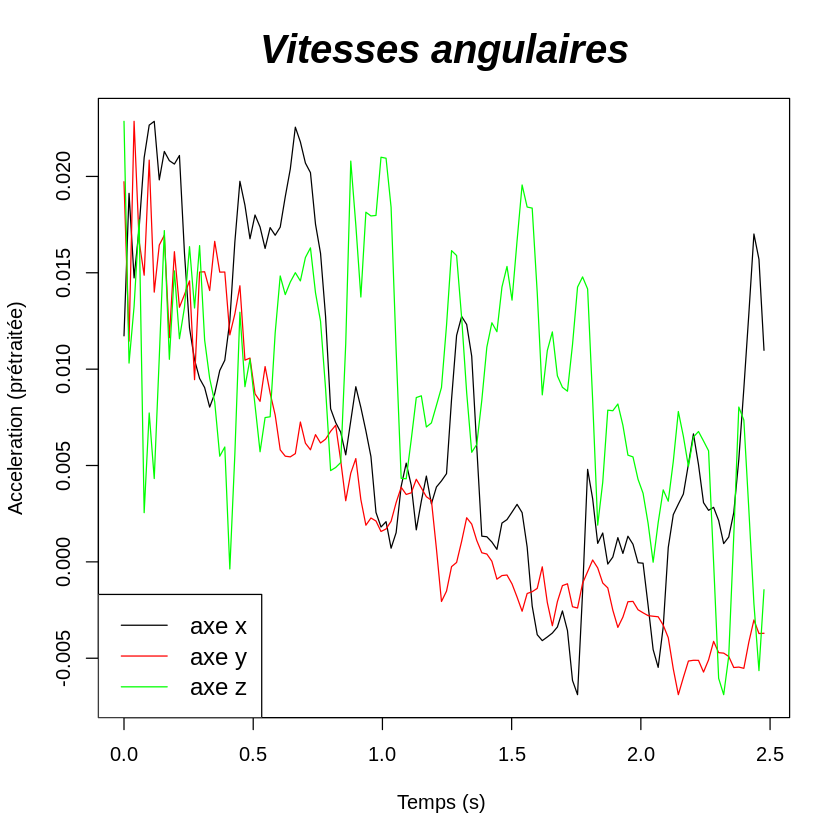

In [ ]:
plot(time_seq, data[1,769:896], type='l', xlab = "", ylab = "", axes=FALSE)
par(new = TRUE)
plot(time_seq, data[1,897:1024], col="red",  type='l' , xlab = "", 
     ylab = "", axes=FALSE)
par(new = TRUE)
plot(time_seq, data[1,1025:1152], col="green",  type='l' , xlab = "", ylab = "")
title(main = "Vitesses angulaires",
      xlab = "Temps (s) ", ylab = "Acceleration (prétraitée)",
      cex.main = 2,   font.main= 4,
      cex.sub = 0.75, font.sub = 3,
      )
legend('bottomleft', legend=c("axe x", "axe y","axe z"),
       col=c("black", "red","green"),lty=1, cex=1.2)

L'objectif est de déterminer, à l'aide de ses séries temporelles, l'activité qu'effectue cet individu. Pour évaluer les algorithmes que nous utiliserons nous utiliserons le tableau `labels` indiquant l'activité correspondante.

Comme  l'on suggéré les auteurs, nous utiliserons le tableau de données `data2`
contenant uniquement 561 variables qui ne sont autres que les variables dans le domaine temps-fréquences. On peux afficher ça pour le premier individu :

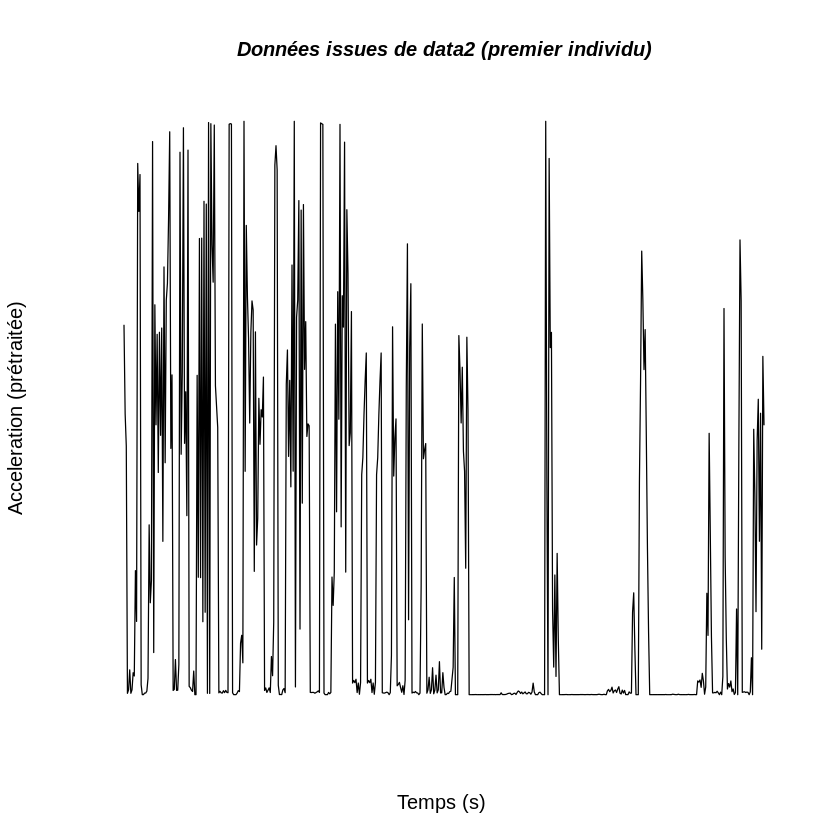

In [ ]:
plot(seq(561), data2[1,], type='l', xlab = "", ylab = "", axes=FALSE)
title(main = "Données issues de data2 (premier individu)",
      xlab = "Temps (s) ", ylab = "Acceleration (prétraitée)",
      cex.main = 1,   font.main= 4,
      cex.sub = 0.75, font.sub = 3
      )

#**Partie 2: classification automatique des données**

##**1. Les packages**

In [ ]:
# téléchargement des librairies
install.packages('plyr')
install.packages('caret')
install.packages('e1071')

In [ ]:
# chargement des librairies
library(cluster)
library(tidyr)
library(caret)  # pour confusionMatrix
library(e1071)

In [ ]:
a=list(1,2,3)
a.raplace(3,2)

ERROR: ignored

### **2. Les méthodes implémentées**


Pour réaliser notre étude, nous avons opté pour l'utilisation de 3 méthodes: **K-means, CAH, K-medoids**. Dans les sections suivantes, nous allons décrire et implémenter chaque méthode.

###**CAH**

CAH (Classification Ascendante Hiérarchique) est une méthode de clustering hiérarchique qui construit une hiérarchie de clusters, le nombre de clusters *k* n’est pas exigé comme donnée. Cette hiérarchie de clusters est appelée *dendrogramme*.

L'inconvénient de cette méthode est que c'est une méthode non extensible: vu la complexité quadratique de la méthode elle ne peut généralement pas être appliquée à de très grands volumes de données.

La fonction `hclust`de R permet d'executer une CAH :

In [76]:
# Matrice des distances
D = dist(as.matrix(data2), method = "euclidean")

# Mise en oeuvre de l'algorithme
H = hclust(D, method="ward.D2")

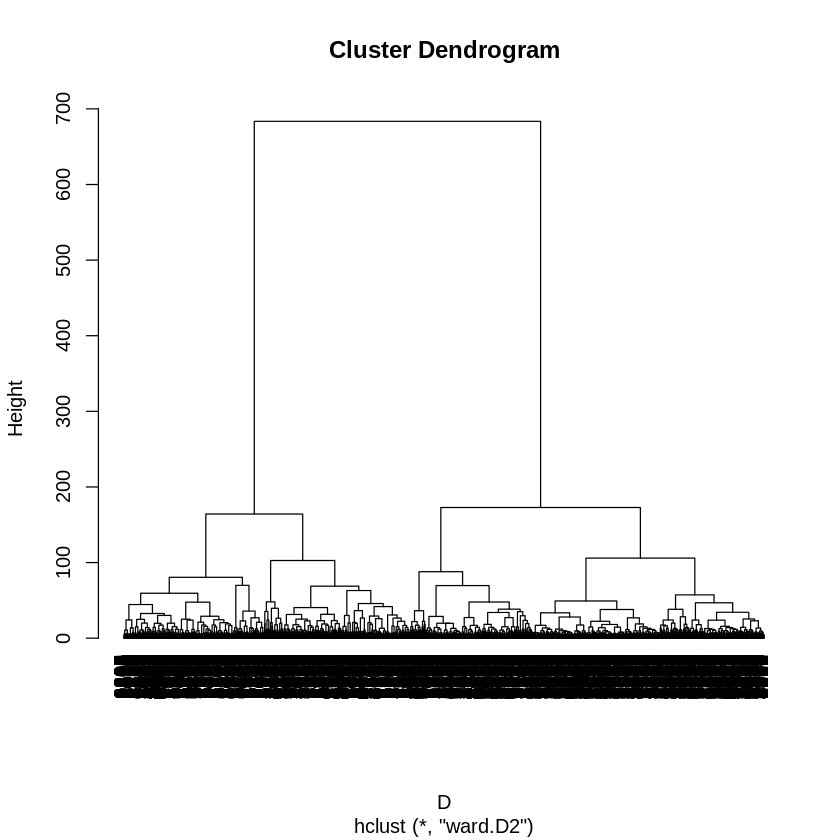

In [ ]:
#Representation graphique du dendrogramme
plot(H,hang=-1)

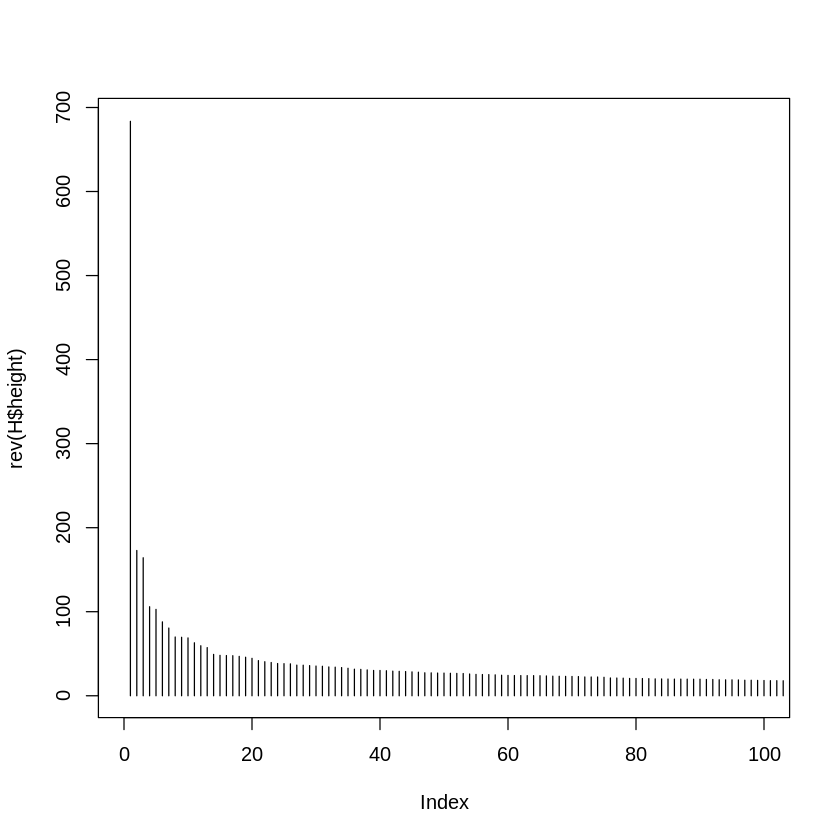

In [ ]:
# Visualisation des paliers décroissants du dendrogramme
plot(rev(H$height),type="h",xlim=c(0,100)) 

Pour déterminer les différentes classes prédites par ce clustering il faut couper les branches du dendrogramme afin d'obtenir 6 classes, comme le montre la représentation ci dessous :

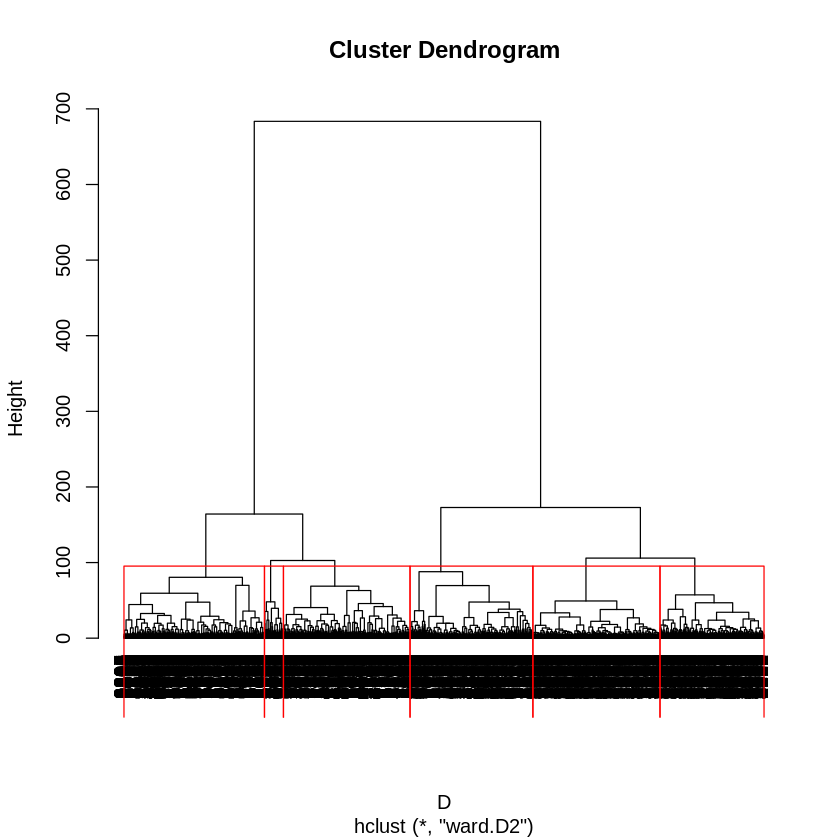

In [ ]:
plot(H,hang=-1)
rect.hclust(H,6,border="red")

La fonction `cutree` réalise la découpe de l'arbre et forme les clusters :

In [ ]:
classes = cutree(H,k=6)

Pour calculer l'effacité du clustering, calculons la matrice de confusion à l'aide des vrais labels `labels` : 

In [ ]:
# Matrice de confusion
confusionMatrix(table(classes, as.matrix(labels)))

Confusion Matrix and Statistics

       
classes    1    2    3    4    5    6
      1    0    0    0  508  687    0
      2    0    0    0  769  687    4
      3    0    0    0    8    0 1403
      4  489  232  733    0    0    0
      5   27    0  191    0    0    0
      6  710  841   62    1    0    0

Overall Statistics
                                    
               Accuracy : 0         
                 95% CI : (0, 5e-04)
    No Information Rate : 0.1914    
    P-Value [Acc > NIR] : 1         
                                    
                  Kappa : -0.1961   
                                    
 Mcnemar's Test P-Value : NA        

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.0000   0.0000   0.0000   0.0000  0.00000   0.0000
Specificity            0.8049   0.7675   0.7784   0.7603  0.96353   0.7285
Pos Pred Value         0.0000   0.0000   0.0000   0.0000  0.00000   0.0000
Neg Pred Value   

On peux supposer que les clusters ne sont pas labellisés dans le même ordre que `labels` : une idée pour corriger ce problème serait de relabelliser nos deux ensembles cibles `labels` et `classes`. 

Pour cela nous avons écrit une fonction python `fancysort()` réorganisant les labels selon leur occurence croissante, prenant en entrée un vecteur et le nombre de labels :

```python
def fancysort(v, nbr):
  dico = {}
  for i in range(nbr):
    dico[i+1] = v.count(i+1)
  tup = sorted(dico.items(), key=lambda t: t[1])
  for j in range(len(tup)):
    v = [str(j+1) if x==tup[j][0] else x for x in v]
  v = [int(i) for i in v]
  return v
```

In [ ]:
# import de fancysort
install.packages("reticulate")
library("reticulate")
source_python("fancysort.py")

In [68]:
ord_classes = fancysort(classes, as.integer(6))
ord_labels = fancysort(c(as.matrix(labels)), as.integer(6))
confusionMatrix(table(ord_classes, ord_labels))

Confusion Matrix and Statistics

           ord_labels
ord_classes    1    2    3    4    5    6
          1  191    0   27    0    0    0
          2    0    0    0  508  687    0
          3    0    0    0    8    0 1403
          4  733  232  489    0    0    0
          5    0    0    0  769  687    4
          6   62  841  710    1    0    0

Overall Statistics
                                          
               Accuracy : 0.1194          
                 95% CI : (0.1121, 0.1271)
    No Information Rate : 0.1914          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : -0.0653         
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity           0.19371   0.0000   0.0000   0.0000  0.50000   0.0000
Specificity           0.99576   0.8097   0.7697   0.7603  0.87069   0.7


Malgré une amélioration des résultats ceux-ci ne sont toujours pas satisfaisants(peut-être que l'ordre choisi n'est pas le bon). Cela nous montre quand même l'inconvénient cité au début de la section de cette méthode, c'est à dire ces résultats sont dus au **nombre trop élévé de données ** utilisées pour cette étude.

### **Kmeans**

K-means clustering est l'un des algorithmes d'apprentissage non supervisé les plus couramment utilisés pour partitionner un ensemble de données.
Il consiste à définir des clusters afin que la variation totale intra-cluster soit minimisée.

La fonction `kmeans()` de R effectue cet algorithme.

In [ ]:
km = kmeans(as.matrix(data2),6,iter.max=10,nstart = 50)
km$cluster # affichage des résultats du clustering


[1] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 4 4 5 4 4 4 4 5 5 5
  [38] 5 4 5 5 5 5 5 5 5 5 5 5 5 5 4 6 6 6 6 6 6 6 6 6 6 6 6 4 4 1 1 4 4 1 1 4 4
  [75] 6 6 6 6 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 2 3 3
 [149] 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 5 5 4 5 5 5 5
 [186] 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 5 5 4 6 6 6 6 6 6 6 6
 [223] 6 6 6 4 4 5 5 5 5 5 5 5 5 5 5 1 4 4 4 4 6 6 6 4 4 4 1 3 3 3 3 3 3 3 3 3 3
 [260] 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 2 2 3 3
 [297] 1 3 3 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3
 [334] 3 3 3 3 3 3 3 3 3 3 2 2 3 3 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 4 5
 [371] 5 5 5 5 5 5 5 4 4 4 5 5 5 5 4 4 4 4 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 4 6 6
 [408] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 3
 [445] 3 1 1 1 3 1 1 1 1 1 3 3 3 1 3 3 3 1 1 3 3 1 3 1 1 1 1 3 1 3 3 3 3 3 3 3 3
 [482] 2 3 3 3 3 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1
 [519] 1 1 1 1 4 4 5 5 4 4 4 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 4 4 4 4
 [556] 5 5 5 5 5 5 5 5 5 1 4 4 4 4 5 5 5 5 5 5 4 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6
 [593] 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3
 [630] 3 3 3 3 3 1 1 1 1 1 3 3 3 3 3 3 3 1 1 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 1 1 1
 [667] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 5 4 4 4 4 4 5 5
 [704] 4 4 4 4 4 5 5 5 5 5 5 5 5 4 4 4 4 5 5 5 4 4 5 5 4 4 4 5 5 5 4 5 5 5 5 4 4
 [741] 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1
 [778] 3 3 1 1 1 1 3 1 1 1 1 1 1 1 3 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 [815] 3 3 3 3 2 2 3 3 1 1 1 1 1 1 1 1 1 3 1 3 3 1 3 3 1 3 1 1 3 3 3 3 3 4 4 4 4
 [852] 4 4 4 4 4 5 5 5 5 5 4 4 4 5 5 5 4 5 5 4 5 5 5 4 4 4 5 5 5 5 5 5 5 5 5 4 4
 [889] 4 4 5 5 5 5 5 5 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 3 3 3 3
 [926] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3
 [963] 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 5 5 5 5 5 5 5
[1000] 5 5 5 5 4 4 4 5 5 4 4 4 4 4 5 5 5 5 5 5 5 4 5 5 4 5 5 5 5 5 5 5 5 5 5 5 4
[1037] 4 5 5 4 4 4 5 5 5 5 5 5 5 4 6 6 6 6 6 6 6 6 6 6 6 6 4 4 6 6 6 6 6 6 6 6 6
[1074] 6 6 6 6 1 3 3 3 1 1 1 1 1 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[1111] 2 2 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 1 1 1 1 3 3 3 3 3 1 3 3 3 3 3 3 3
[1148] 3 3 1 3 3 1 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 4 4 4 4 5 5 5 5 5 5 5 5 4 4
[1185] 4 4 4 4 5 5 5 5 5 5 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 1 4 6 6 6 6 6 6 6 6 6 6
[1222] 6 6 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[1259] 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
[1296] 3 3 3 3 3 3 3 3 3 2 2 3 3 3 2 3 2 2 3 3 4 5 5 5 5 5 4 4 5 5 5 5 5 5 5 4 4
[1333] 4 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 5 5 5 5 4 4 4 4 4 5 5 5 5 5 5 5 5 5
[1370] 1 6 6 6 6 6 6 6 6 6 6 6 6 4 4 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 3 3 3 1 3
[1407] 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 3 3 3 3 3 1 1 1 1 1 1 3 3 2 3
[1444] 3 3 3 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4
[1481] 4 4 4 4 4 5 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 5 5 5 5 5 5 4 4 4 5
[1518] 5 5 5 5 5 5 4 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6 3 3 2 2 2 2
[1555] 3 3 2 2 2 3 3 3 3 3 3 3 3 2 2 3 3 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[1592] 3 3 3 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 5 5 4 5
[1629] 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 4 4 4 5 5 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5
[1666] 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 3 3 3 3 3 3 3 3 3
[1703] 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
[1740] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 5
[1777] 5 5 5 5 5 5 4 4 4 5 5 5 5 4 4 5 5 5 5 5 5 5 5 5 4 4 4 5 5 5 5 5 5 5 5 4 4
[1814] 4 4 4 6 6 6 6 6 6 6 6 6 6 1

In [ ]:
#Taille de chaque cluster
km$size

[1] 1551  356 1389  882 1891 1283

`km$size` renvoie le nombre d'individus dans chaque cluster.

Le graphe ci-dessous nous illustre la distribution du nombre d'éléments dans chaque clusters.

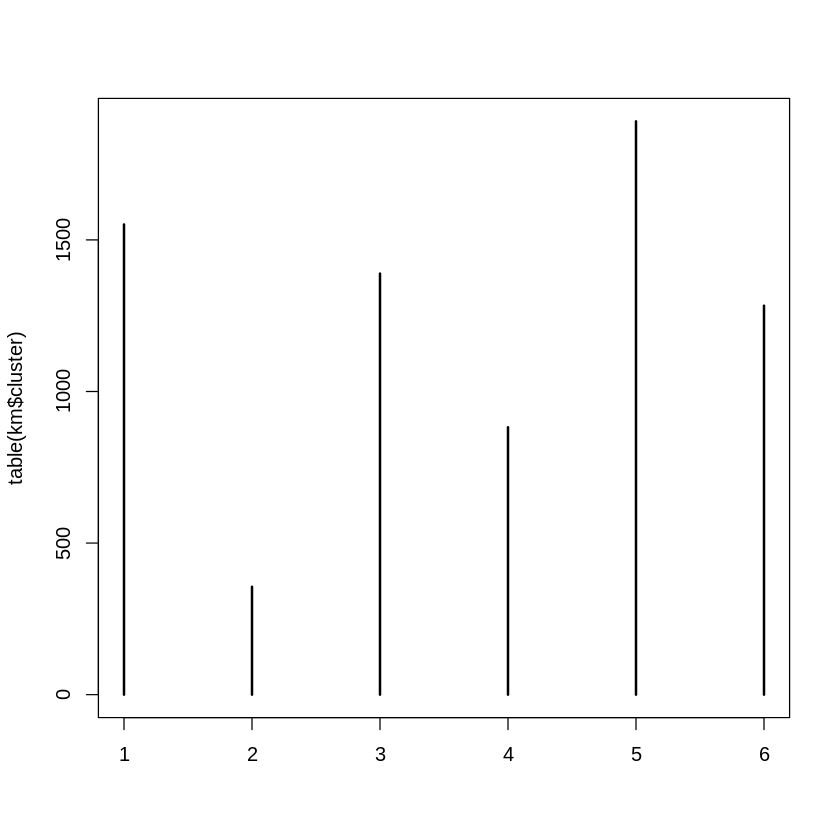

In [ ]:
plot(table(km$cluster))

Pour pouvoir comparer les résultats obtenus aux vraies classes, nous avons calculé la matrice de confusion entre les `km$cluster` et les vrais labels.
Cette matrice permet de mesurer la qualité d'un système de classification.

Ainsi nous avons obtenu les résultats suivants: 

In [ ]:
confusionMatrix(table(km$cluster,as.matrix(labels)))

Confusion Matrix and Statistics

   
       1    2    3    4    5    6
  1  595  810  135    1    0   10
  2   84   49  223    0    0    0
  3  547  214  628    0    0    0
  4    0    0    0  306  413  163
  5    0    0    0  930  961    0
  6    0    0    0   49    0 1234

Overall Statistics
                                          
               Accuracy : 0.5132          
                 95% CI : (0.5017, 0.5247)
    No Information Rate : 0.1914          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4135          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity           0.48532 0.045666  0.63692  0.23795   0.6994   0.8770
Specificity           0.84394 0.951107  0.88046  0.90504   0.8444   0.9918
Pos Pred Value        0.38362 0.137640  0.45212  0.34694   0.5082   0.

Selon les résultats ci dessus, nous remarquons que nous avons obtenu une accuracy de 0.5132, cela signifie que l'algorithme n'a pas pu détecter correctement toutes les classes, ce que nous montre la matrice de confusion.

On peux essayer notre fonction `fancysort` : 

In [75]:
ord_classes = fancysort(km$cluster, as.integer(6))
ord_labels = fancysort(c(as.matrix(labels)), as.integer(6))
confusionMatrix(table(ord_classes, ord_labels))

Confusion Matrix and Statistics

           ord_labels
ord_classes    1    2    3    4    5    6
          1  223   49   84    0    0    0
          2    0    0    0  306  413  163
          3    0    0    0   49    0 1234
          4  628  214  547    0    0    0
          5  135  810  595    1    0   10
          6    0    0    0  930  961    0

Overall Statistics
                                          
               Accuracy : 0.0303          
                 95% CI : (0.0265, 0.0345)
    No Information Rate : 0.1914          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : -0.1751         
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity           0.22617   0.0000   0.0000   0.0000   0.0000   0.0000
Specificity           0.97911   0.8595   0.7906   0.7710   0.7405   0.6

Ce réarrangement n'est pas le bon, on gardera plutôt les précédents résultats.

###**K-medoides**

L'algorithme k-medoids est une approche de clustering liée à la méthode k-means pour partitionner un ensemble de données en k groupes ou clusters. Dans la méthode k-medoids, chaque cluster est représenté par l'un des points de données du cluster. Ces points sont appelés médoïdes de cluster.

La méthode de classification des k-médoïdes la plus courante est l'algorithme PAM (Partitioning Around Medoids), qui est basé sur la recherche de k objets représentatifs ou médoïdes parmi les observations de l'ensemble de données.

Dans la suite de cette section, nous allons voir les différentes fonctions implémentées.

In [70]:
#lancer l'algo PAM pour k=6 clusters
data2.pam = pam(as.matrix(data2),6)

On peux afficher les signaux médoides de chaque clusters :

In [71]:
#Médoides des clusters
data2.pam$medoids
#affichage comme la partie1

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V552,V553,V554,V555,V556,V557,V558,V559,V560,V561
0.2766697,-0.018357824,-0.1060668,-0.9974498,-0.9898275,-0.9903740,-0.99751715,-0.9908267,-0.99010606,-0.9446420,⋯,0.29594814,-0.64918565,-0.9049180,0.09160747,-0.21553652,0.20141514,-0.15338766,-0.8489000,0.1961496,0.05555708
0.2805776,-0.015260767,-0.1241410,-0.9867640,-0.9339637,-0.8963278,-0.98991579,-0.9381902,-0.88828020,-0.9128602,⋯,-0.20643012,-0.01926086,-0.3088329,0.02051861,0.02389111,-0.15168239,-0.72858413,-0.7320822,0.2717236,-0.04799912
0.2891905,-0.016912076,-0.1092038,-0.9926694,-0.9759279,-0.9902633,-0.99342405,-0.9774885,-0.99114220,-0.9331565,⋯,0.25183306,-0.54375784,-0.8400636,-0.03668784,-0.01638050,0.16499070,0.59506182,0.4853537,-0.5305157,-0.46714544
0.2611791,-0.025127230,-0.1173050,-0.5250103,-0.1369068,-0.0911632,-0.55161881,-0.1295005,-0.09630599,-0.4104405,⋯,0.01818877,-0.27827242,-0.6315887,0.10440727,0.02008657,-0.00797914,-0.05675592,-0.5398047,0.2642848,0.29478459
0.2518132,0.008052528,-0.1064744,-0.2448454,-0.1060807,-0.3475413,-0.28890642,-0.1281093,-0.37785568,0.1149864,⋯,-0.12853550,-0.06155833,-0.5102343,0.38409681,-0.65193715,-0.19912529,0.30102863,-0.7535382,0.2398373,0.11524360
0.3788826,-0.026526494,-0.1279413,0.1476688,0.1881156,-0.1750894,0.08569533,0.2053752,-0.22983269,0.5430981,⋯,0.24836067,-0.46428860,-0.7442145,-0.90010637,-0.79732150,0.29127735,-0.83772980,-0.7482387,0.2425819,0.11772924


In [72]:
# création du vecteurs de labels
clusters_kmd = data2.pam$clustering
clusters_kmd

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 2 1 1 1
  [38] 1 2 2 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 4 4 2 2 4 4 2 2
  [75] 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 6 5 5 5 5 6 5 6 5 5 5 5 5 5 6
 [112] 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 5
 [149] 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 1 2 2 1 1 1 1
 [186] 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3
 [223] 3 3 3 2 2 1 1 1 1 1 1 1 1 1 1 4 4 2 2 2 3 3 3 2 2 3 5 5 5 5 5 5 5 5 5 6 5
 [260] 5 5 5 5 5 6 5 5 6 6 6 5 6 6 6 6 5 5 6 5 5 5 5 6 5 5 5 5 5 6 6 6 5 6 6 5 5
 [297] 5 5 6 6 6 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6
 [334] 6 5 6 6 6 5 6 6 6 6 6 6 6 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2
 [371] 2 1 1 1 1 1 1 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 1 1 1 1 2 2 1 1 1 1 2 3 3
 [408] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5
 [445] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5 5 6 6
 [482] 6 6 6 6 6 6 6 4 4 4 4 4 4 4 4 4 5 5 5 4 4 5 5 4 4 5 4 4 5 4 5 5 4 5 5 5 5
 [519] 5 5 5 5 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
 [556] 1 1 1 1 1 1 1 1 1 4 2 2 2 2 2 1 1 1 1 1 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 [593] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [630] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 6 6 5 5 5 6 4 4 5
 [667] 5 4 4 5 5 4 5 5 4 4 5 5 5 4 5 5 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 [704] 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 2 1 1 2 2 2 3 3 2 2 2 2 1 2 2 1 1 1 1 2 2
 [741] 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5
 [778] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 6 5 6 6 5 6 5 5 5 5 5 6 5 5
 [815] 6 6 5 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2
 [852] 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2
 [889] 2 2 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5
 [926] 5 5 5 5 5 5 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 [963] 6 6 6 6 5 6 5 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5 5 6 2 2 2 2 1 1 2 2 2
[1000] 1 1 1 2 2 2 2 1 1 2 2 2 2 2 1 1 2 1 1 2 2 2 1 2 2 1 1 1 1 2 1 2 1 1 1 2 2
[1037] 2 2 1 2 2 2 2 1 1 1 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3 4 2 3 3 3 3 3 3 3 3 3
[1074] 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6
[1111] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1148] 6 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 2 2
[1185] 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 5 4 3 3 3 3 3 3 3 3 3 3
[1222] 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 6 6 5 6 6 6 5 5 5 6 5 5 5 6 6 6 5 5 6 5
[1259] 6 6 6 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1296] 6 6 5 5 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 5 2 2 1 1 1 1 2 2 1 1 1 1 1 1 2 2 2
[1333] 2 1 1 1 1 1 2 1 2 2 1 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1
[1370] 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 5 5 5 5 5 5 5 5
[1407] 5 6 6 5 5 5 5 5 5 5 5 5 5 4 5 6 6 5 5 5 5 5 6 6 5 6 5 5 5 5 4 5 5 5 6 6 6
[1444] 6 6 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2
[1481] 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2
[1518] 2 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 6 6 6 6
[1555] 5 6 6 6 6 5 6 5 5 5 6 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1592] 6 6 6 6 6 6 5 5 4 4 4 5 4 4 4 4 5 5 4 4 4 4 5 5 5 5 5 5 4 4 4 4 2 2 2 2 2
[1629] 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1
[1666] 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 6 5 5 5 5 5 5 5
[1703] 5 5 5 5 5 6 5 5 5 6 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5
[1740] 5 6 6 4 6 6 5 6 5 6 6 6 6 6 6 6 6 5 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1
[1777] 1 1 1 1 1 2 2 2 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 2 2 2
[1814] 4 3 3 3 3 3 3 3 3 3 3 3 3 4

On calcule alors l'accuracy à l'aide de la matrice de confusion :

In [73]:
# Matrice de confusion
confusionMatrix(table(clusters, as.matrix(labels)))

Confusion Matrix and Statistics

        
clusters    1    2    3    4    5    6
       1    0    0    0  827  808    0
       2    0    0    0  408  566  112
       3    0    0    0   50    0 1272
       4  220  593   31    1    0   22
       5  807  378  289    0    0    1
       6  199  102  666    0    0    0

Overall Statistics
                                    
               Accuracy : 1e-04     
                 95% CI : (0, 8e-04)
    No Information Rate : 0.1914    
    P-Value [Acc > NIR] : 1         
                                    
                  Kappa : -0.199    
                                    
 Mcnemar's Test P-Value : NA        

Statistics by Class:

                     Class: 1 Class: 2 Class: 3  Class: 4 Class: 5 Class: 6
Sensitivity            0.0000   0.0000   0.0000 0.0007776   0.0000   0.0000
Specificity            0.7331   0.8270   0.7923 0.8572371   0.7533   0.8373
Pos Pred Value         0.0000   0.0000   0.0000 0.0011534   0.0000   0.0000
Neg P

En réorganisant avec `fancysort` on obtient :

In [74]:
ord_classes = fancysort(clusters_kmd, as.integer(6))
ord_labels = fancysort(c(as.matrix(labels)), as.integer(6))
confusionMatrix(table(ord_classes, ord_labels))

Confusion Matrix and Statistics

           ord_labels
ord_classes    1    2    3    4    5    6
          1   31  593  220    1    0   22
          2  666  102  199    0    0    0
          3    0    0    0  408  566  112
          4    0    0    0   50    0 1272
          5  289  378  807    0    0    1
          6    0    0    0  827  808    0

Overall Statistics
                                          
               Accuracy : 0.0249          
                 95% CI : (0.0215, 0.0287)
    No Information Rate : 0.1914          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : -0.1765         
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity          0.031440  0.09506   0.0000 0.038880   0.0000   0.0000
Specificity          0.868677  0.86224   0.8227 0.790307   0.7533   0.7

Selon les résultats obtenus via la matrice de confusion, nous remarquons que le taux de l'accuracy est très faible, un peu plus d'une centaine de la classe réelle n'a été estimé comme appartenant à la classe estimée. L'algorithme n'a pu détecter qu'un seul élément de la classe 4.

###**Classification en série temporelles**

**Métrique adaptée aux séries temporelles** 

Nous avons ici affaire à des séries temporelles, nous avons vu ici que mes méthodes utilisées précedemment ne sont pas forcément adaptées à notre situation et voient chacunes des variables indépendamment.

Or ce sont des mesures de signaux qu'il serait préférable de considérer dans leur entierté, en utilisant des métriques adaptés que l'on appliquera avec les fonctions données parles packages suivants :

In [ ]:
install.packages('TSdist')  # installe aussi TSclust

In [ ]:
library(TSdist)
library(TSclust)

La méthode est d'utiliser une metrique de dissimilarité adaptée et ensuite d'appliquer
un algorithme de classification non supervisée, comme par exemple la CAH ou k-medoides. 

In [ ]:
#calcule de la matrice de dissimilarité
 = diss(data2, "DTW")

On choisit la distance DTW Dynamic Time Warping et on applique la méthodes des K-medoides :

In [ ]:
# utilisation de la métrique DTW et l'algorithme PAM de k-medoides
clus.dtw = pam(mat.dtw, k=6,  diss=TRUE)  

<font color='red'>**Le code n'a jamais fini de tourner sur nos machines donc nous ne pouvons pas dégager de résultats**

**Autre méthode** 

L'utilisation des coefficients de Fourier pour classifier les signaux et aussi une bonne idée dans notre cas de figure : essayons de réaliser ce clustering avec cette décomposition et la méthode `"fourrier"`de `KMedoides`

*N.B. la décomposition en ondelettes est aussi une bonne méthode*

In [ ]:
clus.four = KMedoids(data=data2_2, k=6, "fourier")

<font color='red'>**Le code n'a jamais fini de tourner sur nos machines donc nous ne pouvons pas dégager de résultats**

Les résultats espérés devraient être bien meilleurs que les 3 classification non supervisée **CAH**, **Kmeans** et **k-medoides**.